# Modello convolutivo di base
Di seguito verrà creato un **modello convolutivo di base** con un'architettura semplice. In seguito, sarà interessante confrontare i risultati di questo primo modello con i risultati ottenuti da modelli più complessi, o pre addestrati. 

Come è solito, si procede con l'importazione delle librerie utilizzate e la creazione dei set di allenamento e validazione.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio', 
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True, 
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


In [3]:
for audios, labels in train_ds:
    print("Forma (shape) audio:", audios.shape)
    print("Forma (shape) classi:", labels.shape)
    break

Forma (shape) audio: (32, 16000, 1)
Forma (shape) classi: (32,)


Lo shape dell'audio è di (32, 16000, 1), indicando che ogni file è contenuto in un batch di 32 tensori unidimensionali di lunghezza 16000. Inoltre, lo shape delle classi è anch'esso 32. Questo perché la funzione `tf.keras.utils.audio_dataset_from_directory(directory)` ha il parametro `batch_size` impostato a 32 di default, non avendolo specificato la dimensione è rimasta tale.

## Funzioni per processamento dei dati

Il prossimo step è definire la funzione `squeeze(audio, labels)`, la quale prende come argomenti l'audio e le classi. 

Questo funzione serve per rimuovere l'ultimo asse dello shape dai nostri audio. Attualmente, lo shape dei dati è (32, 16000, 1), ma si può eliminare l'ultima dimensione poiché non necessaria. Specificando il parametro **axis=-1** nella funzione `tf.squeeze` la forma dell'audio viene trasformata in (32, 16000).

Eseguiamo questa semplificazione sulla forma del dato poiché rende la fase di processamento dei dati più efficiente.

In [4]:
def squeeze(audio, labels): 
    audio = tf.squeeze(audio, axis=-1) 
    return audio, labels 

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [5]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE) 
validation_ds = validation_ds.map(squeeze, tf.data.AUTOTUNE)

audio, label = next(iter(train_ds))
print(audio.shape)
print(label.shape)

(32, 16000)
(32,)


Una volta eseguito questa semplificazione, a partire dai tensori degli audio, creeremo gli spettrogrammi che sarannò presi come input dal modello convolutivo.

## Conversione e suddivisione dataset
Andremo ad utilizzare due funzioni: `get_spectrogram` e `get_spectrogram_dataset`. Queste due funzioni usate insieme creano un dataset di spettrogrammi. La prima funzione `get_spectrogram` converte il singolo audio in spettrogramma mentre la seconda funzione `get_spectrogram_dataset` richiama la prima funzione per ogni dato presente nel dataset.

In [6]:
def get_spectrogram(waveform): 
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
    spectrogram = tf.abs(spectrogram) 
    
    return spectrogram[..., tf.newaxis] 

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [7]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

Definite le due funzioni possiamo procedere a ottenere il nostro training set, validation set, e test set di spettrogrammi. La suddivisione di dati ricordo essere rispettivamente 60%, 20%, 20%.

In [8]:
train_ds = get_spectrogram_dataset(train_ds)
validation_ds = get_spectrogram_dataset(validation_ds)

val_ds = validation_ds.take(validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
test_ds = validation_ds.skip(validation_ds.cardinality() // 2)

In [9]:
print("Numero di audio training set:", len(train_ds) * 32)
print("Numero di audio validation set:", len(val_ds) * 32)
print("Numero di audio test set:", len(test_ds) * 32)

Numero di audio training set: 7776
Numero di audio validation set: 2592
Numero di audio test set: 2592


Shape (forma) spettrogrammi: (32, 124, 129, 1)


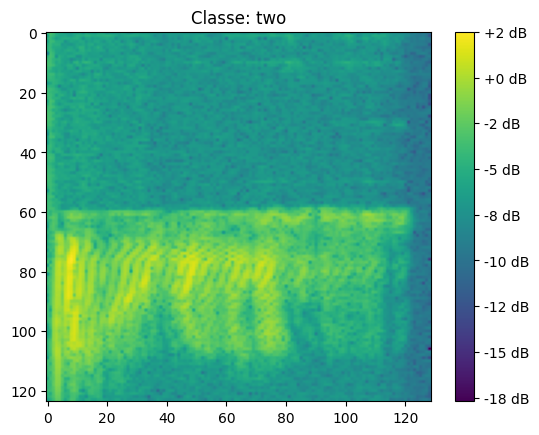

In [61]:
for audio, label in train_ds:
    print("Shape (forma) spettrogrammi:", audio.shape)

    spectrogram = np.squeeze(audio[0])
    spectrogram = np.log(spectrogram.T)
    
    plt.imshow(spectrogram.T)
    plt.colorbar(format='%+2.0f dB')
    
    plt.title(f"Classe: {label_names[label[0].numpy()]}")
    break

La grandezza degli spettrogrammi, e quindi delle immagini ottenute, è di **124x129**.

## Creazione modello di base

AGGIUNGERE DESCRIZIONE MODELLI CONVOLUTIVI

In [11]:
def get_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Resizing(120, 120)(inputs)
    x = tf.keras.layers.Normalization()(x)

    # Livelli per l'apprendimento della rappresentazione delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    
    # Livelli per la classificazione
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)
    
    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

SPIEGHIAMO IL MODELLO DI BASE

In [12]:
model = get_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing (Resizing)         (None, 120, 120, 1)       0         
                                                                 
 normalization (Normalizatio  (None, 120, 120, 1)      3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 116, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 58, 32)       0         
 )                                                           

SPIEGHIAMO IL SUMMARY IN POCHE PAROLE

ORA ADDESTRIAMO PER 30 EPOCHE SPIEGHIAMO

In [13]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/convnet_from_scratch.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
243/243 [==============================] - 8s 19ms/step - loss: 2.4140 - accuracy: 0.3562 - val_loss: 1.6572 - val_accuracy: 0.5347
Epoch 2/30
243/243 [==============================] - 4s 18ms/step - loss: 1.0192 - accuracy: 0.7237 - val_loss: 1.4187 - val_accuracy: 0.6505
Epoch 3/30
243/243 [==============================] - 4s 18ms/step - loss: 0.5201 - accuracy: 0.8540 - val_loss: 1.2615 - val_accuracy: 0.7531
Epoch 4/30
243/243 [==============================] - 4s 17ms/step - loss: 0.2763 - accuracy: 0.9204 - val_loss: 1.9812 - val_accuracy: 0.6694
Epoch 5/30
243/243 [==============================] - 4s 17ms/step - loss: 0.1713 - accuracy: 0.9537 - val_loss: 2.0343 - val_accuracy: 0.7577
Epoch 6/30
243/243 [==============================] - 4s 17ms/step - loss: 0.1229 - accuracy: 0.9687 - val_loss: 2.3060 - val_accuracy: 0.7323
Epoch 7/30
243/243 [==============================] - 4s 17ms/step - loss: 0.0931 - accuracy: 0.9780 - val_loss: 2.6955 - val_accuracy: 0.7427

Ora visualizziamo le **curve di addestramento** e **validazione**. FORSE AGGIUNGIAMO COMMENTI

In [14]:
def create_train_val_plot(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Accuratezza in addestramento")
    plt.plot(epochs, val_accuracy, "b", label="Accuratezza in validazione")
    plt.title("Accuratezza in addestramento e validazione")
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, "bo", label="Loss in addestramento")
    plt.plot(epochs, val_loss, "b", label="Loss in validazione")
    plt.title("Loss in addestramento e validazione")
    plt.legend()
    
    plt.show()

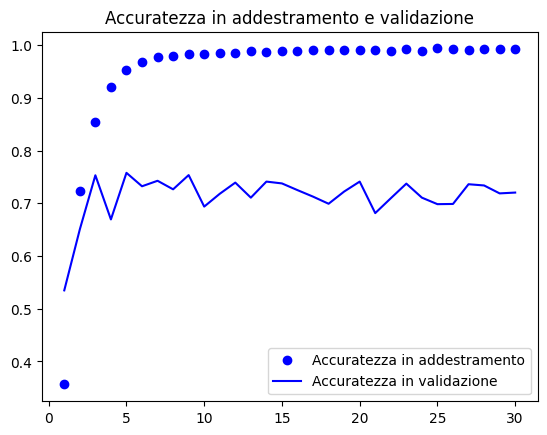

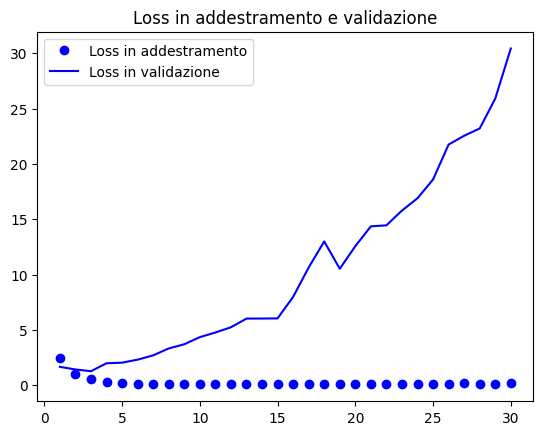

In [15]:
create_train_val_plot(history)

Questi grafici mostrano come il nostro modello sia andato immediatamente in overfitting. L'accuratezza dell'addestramento aumenta col tempo e raggiunge quasi il **100%**, mentre l'accuratezza della validazione varia dal **70% al 80%** con un picco del 78%. Inoltre la **perdita nel set di addestramento** continua a diminuire mentre la **perdita nel set di validazione** aumenta.

Possiamo verificare l'accuratezza della migliore versione del nostro modello di base ricaricando il file **convnet_from_scratch.keras (CAMBIAMO NOME POI)**.

In [13]:
best_model = tf.keras.models.load_model("bestmodels/convnet_from_scratch.keras")
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 7s 7ms/step - loss: 1.3990 - accuracy: 0.7315
Accuratezza: 0.731


ANDREA SCRIVI TU IN QUESTA CELLA

CREARE DISTRIBUZIONE ACCURATEZZA SU CLASSI

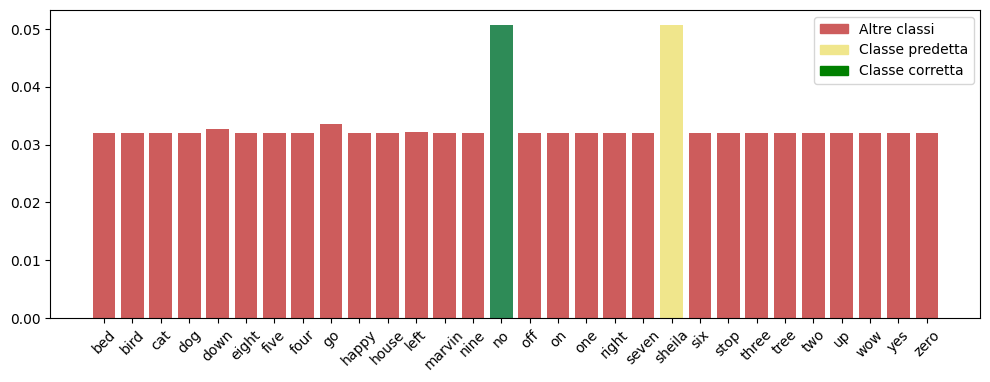

In [19]:
for audio, label in test_ds:
    prediction = best_model(audio)
    softmax_pred = tf.nn.softmax(prediction[0])
    pred_label = np.argmax(softmax_pred)

    colors = ['indianred'] * len(labels)

    if pred_label == label[0].numpy():
        colors[pred_label] = 'seagreen'
    else:
        colors[pred_label] = 'khaki'
        colors[label[0].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))
    
    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    if pred_label == label[0].numpy():
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])
    
    plt.show()
    break

PROVIAMO AL DATA AUGMENTATION